In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Data Preprocessing

I am using some data from the original dataset for culling, as the new data set isn't clean enough for it

In [11]:
train=pd.read_csv('data_set_ALL_AML_train.csv').T
train = train.drop([c for c in train.index if 'call' in c],axis=0)
independent=pd.read_csv('data_set_ALL_AML_independent.csv').T
independent = independent.drop([c for c in independent.index if 'call' in c],axis=0)
labels=pd.read_csv('actual.csv')
data = pd.concat([train[2:],independent[2:]]).astype(int)
data.index = data.index.map(int)
data = data.sort_index()
data.tail()

,0,1,2,3,4,5,6,7,8,9,...,7119,7120,7121,7122,7123,7124,7125,7126,7127,7128
68,-154,-136,49,180,-257,-273,141,-123,52,878,...,214,540,13,1075,-45,524,249,40,-68,-1
69,-79,-118,-30,68,-110,-264,-28,-61,40,-217,...,409,617,-34,738,11,742,234,72,109,-30
70,-55,-44,12,129,-108,-301,-222,-133,136,320,...,131,318,35,241,-66,320,174,-4,176,40
71,-59,-114,23,146,-171,-227,-73,-126,-6,149,...,214,760,-38,201,-55,348,208,0,74,-12
72,-131,-126,-50,211,-206,-287,-34,-114,62,341,...,206,697,3,1046,27,874,393,34,237,-2


In [5]:
target = np.where(labels['cancer']=='ALL',1,-1)
results=[]
for i in range(0,7129):
    if abs(np.corrcoef(train[2:][i].to_numpy(dtype=int),target[:38])[1,0])>0.3:
        results+=[i]
train = train[2:].filter(results)
data=data.filter(results)
independent = data[38:]

Next I pull out the other dataset, remove some metadata, and then split between train and test

In [45]:
d = pd.read_csv('golub.csv')
k=d.T[6:].T
k=k.filter(k.columns[results])
k
from sklearn.model_selection import train_test_split
X=k
y=d['cancer']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)
X_train.head()

,AFFX-BioC-5_at,AFFX-CreX-5_at,AFFX-CreX-5_st,AFFX-DapX-5_at,AFFX-LysX-M_at,AFFX-PheX-M_at,AFFX-ThrX-5_at,AFFX-HUMISGF3A/M97935_5_at,AFFX-HUMISGF3A/M97935_MA_at,AFFX-HUMGAPDH/M33197_5_at,...,L42583_f_at,L42601_f_at,L42611_f_at,V01516_f_at,X97444_f_at,Z34822_f_at,U11863_at,U29175_at,X83863_at,M71243_f_at
70,-135.921851,-1340.526207,-1005.066766,-811.197349,-1146.65679,-1360.13098,-1168.439871,-1458.154842,-933.1826,32900.298147,...,691.83521,338.949305,2597.854761,352.019153,593.811348,-1612.814714,-6354.991355,643.912433,1693.856917,-205.627709
48,-609.068317,-1346.227683,-1207.182653,-827.56765,-1094.62239,-1039.445791,-1163.041373,-1032.824599,373.07515,37522.375894,...,-61.716452,-169.862587,752.690153,-372.912472,-481.058607,-1246.909804,-1829.574692,2672.835807,-507.543374,-681.901428
56,-637.793773,-821.47716,-699.759253,-425.340699,-763.937785,-682.05483,-666.56346,-896.720957,-690.907041,36495.020055,...,200.953259,311.605901,1391.575694,900.27796,238.575157,-1157.861193,-2983.629797,2489.249909,807.329741,-20.352027
25,-75.669918,-487.454105,-792.479428,-685.720565,-629.073005,-470.024086,-382.873994,-1104.041008,-1090.968494,32821.311188,...,669.463371,375.331809,734.82594,540.916985,194.495368,-731.474363,-3546.422346,403.655589,641.139591,-32.094872
1,83.544731,-1636.960108,-971.329722,-547.537365,-409.344205,-1134.858294,-540.627707,-1556.347431,-1952.501156,24177.522133,...,686.988195,251.679742,2103.468083,657.046344,67.422196,-1296.083647,-6137.450677,2451.254201,-441.589276,-671.911209


# Self Organizing Map

I use a 8 by 8 map here, as a 2 by 2 doesn't seem to be accurate enough for this analysis.

In [13]:
from minisom import MiniSom
n_neurons = 8
m_neurons = 8
som = MiniSom(n_neurons, m_neurons, k.shape[1], sigma=1.5, learning_rate=.5, 
              neighborhood_function='gaussian', random_seed=0)
# target = np.where(labels['cancer']=='ALL',1,0)[:38]
t = X_train.to_numpy(dtype=int)
t = (t - np.mean(t, axis=0)) / np.std(t, axis=0)
som.pca_weights_init(t)
som.train(t, 100000, verbose=True)

C:\Users\Victor\AppData\Local\Programs\Python\Python37\lib\site-packages\minisom.py:370: ComplexWarning: Casting complex values to real discards the imaginary part
  self._weights[i, j] = c1*pc[pc_order[0]] + c2*pc[pc_order[1]]


 [ 100000 / 100000 ] 100% - 0:00:00 left 
 quantization error: 17.168684323947115


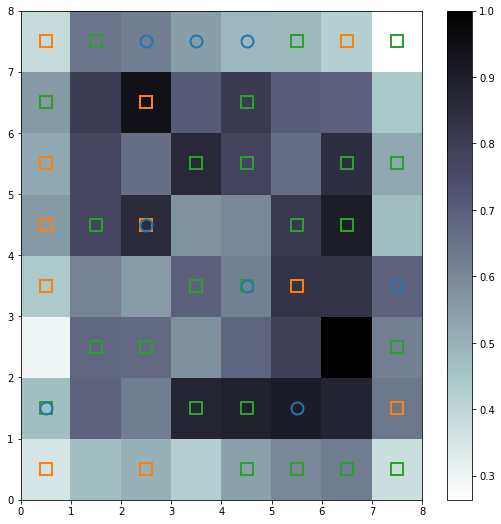

In [14]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(9, 9))

plt.pcolor(som.distance_map().T, cmap='bone_r')
plt.colorbar()

markers = ['o', 's']
colors = ['C0', 'C1','C2']
for cnt, xx in enumerate(t):
    w = som.winner(xx)  
    plt.plot(w[0]+.5, w[1]+.5, markers[target[cnt]-1], markerfacecolor='None',
             markeredgecolor=colors[target[cnt]-1], markersize=12, markeredgewidth=2)

plt.show()

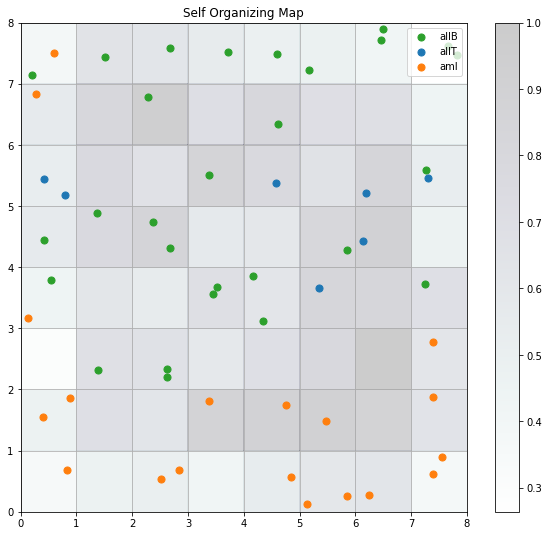

In [15]:
w_x, w_y = zip(*[som.winner(x) for x in t])
w_x = np.array(w_x)
w_y = np.array(w_y)
colors = ['C0', 'C1','C2']
plt.figure(figsize=(10, 9))
plt.pcolor(som.distance_map().T, cmap='bone_r', alpha=.2)
plt.colorbar()
target=[{"allB":0,"allT":1,"aml":2}[x] for x in y_train]
for c in np.unique(target):
    idx_target = target==c
    plt.scatter(w_x[idx_target]+.5+(np.random.rand(np.sum(idx_target))-.5)*.8,
                w_y[idx_target]+.5+(np.random.rand(np.sum(idx_target))-.5)*.8, 
                s=50, c=colors[c-1], label=(["allB","allT","aml"])[c])
plt.legend(loc='upper right')
plt.title("Self Organizing Map")
plt.grid()
plt.show()

In [40]:
from sklearn.model_selection import train_test_split
a=np.array([0,1])
df=pd.DataFrame(columns=['real','prediction'])
df['real']=y_test

# Modified from https://github.com/JustGlowing/minisom/blob/master/examples/Classification.ipynb
square = [0,1,0,-1,0]
def classify(som, data):
    """Classifies each sample in data in one of the classes definited
    using the method labels_map.
    Returns a list of the same length of data where the i-th element
    is the class assigned to data[i].
    """
    winmap = som.labels_map(X_train.to_numpy(dtype=float), y_train)
    result = []
    default_class = np.sum(list(winmap.values())).most_common()[0][0]
    for d in data:
        win_position = som.winner(d)
        if win_position in winmap:
            result.append(winmap[win_position].most_common()[0][0])
        else:
            s=[]
            for i in range(0,4):
                p = tuple(sum(x) for x in zip(win_position, (square[i],square[i+1])))
                if p in winmap:
                    s.append(winmap[p])
            if(not np.sum(s) == 0):
                result.append(np.sum(s).most_common()[0][0])
            else:
                result.append(default_class)
    return result
df['prediction'] = classify(som,X_test.to_numpy(dtype=int))

Accuracy: 0.8333333333333334


Text(0.5, 1.0, 'SOM')

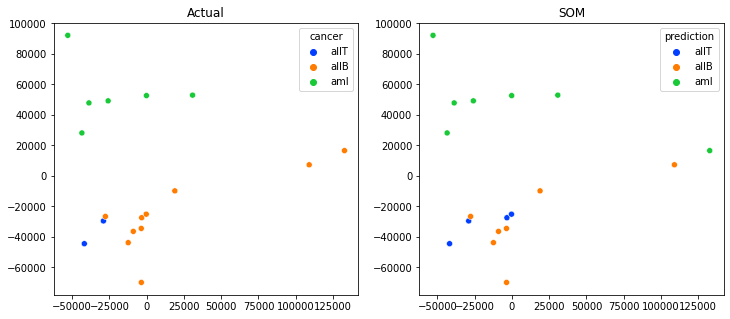

In [44]:
from sklearn.decomposition import PCA
c=0
for v in df.values:
    if v[1] == v[0]: c+=1
print('Accuracy:',c/y_test.size)

pca = PCA(n_components=3)
pca_result = pca.fit_transform(X_test)

fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12,5))
# actual
palette = sns.color_palette("bright", 3)
sns.scatterplot(x=pca_result[:,0], y=pca_result[:,1], hue=y_test, legend='full', palette=palette,ax=ax1)
ax1.set_title('Actual')
# som
palette = sns.color_palette("bright", 3)
sns.scatterplot(x=pca_result[:,0], y=pca_result[:,1], hue=df['prediction'], legend='full', palette=palette,ax=ax2)
ax2.set_title('SOM')

This isn't as accurate as the previous result, but shows some promise that it might be viable with proper tuning and a better sample